In [1]:
using NextGenSeqUtils, PyPlot, DataFrames, CSV

In [2]:
robust_translate(nuc_seq) = translate_to_aa(nuc_seq[1:3*Int(floor(end/3))])

function early_stop(nuc_seq)
    trans = robust_translate(nuc_seq)
    if !occursin("*",trans)
        return false
    else
        return findfirst("*",trans)[1]/length(trans) < 0.95
    end
end

function seq_neighbours(seq,fnames; thresh = 0.03)
    search_kmer = kmer_count(uppercase(seq),5);
    match_names = ["Query"]
    match_seqs = [seq]
    for fname in fnames
        seqnames,seqs = read_fasta_with_names(fname);
        sizes = [parse(Int,split(n,"_")[end]) for n in seqnames];
        sizes = sizes ./ sum(sizes);
        panned_kmers = [kmer_count(s,5) for s in seqs];
        
        all_dists = [corrected_kmer_dist(search_kmer,pk) for pk in panned_kmers]
        partial_matches = all_dists .< thresh
        match_names = vcat(match_names,seqnames[partial_matches] .* "_" .* string.(sizes[partial_matches]))
        match_seqs = vcat(match_seqs,seqs[partial_matches])
    end
    return match_names,match_seqs
end

function kmer_keep(seqs; thresh = 0.03)
    kmers = kmer_count.(uppercase.(seqs),5)
    drop_inds = []
    for i in 1:length(kmers)
        for j in i+1:length(kmers)
            if corrected_kmer_dist(kmers[i],kmers[j]) < thresh
                push!(drop_inds,j)
            end
        end
    end
    drop_inds = union(drop_inds)
    bitvec = [true for i in 1:length(kmers)]
    bitvec[drop_inds] .= false
    return bitvec
end

kmer_keep (generic function with 1 method)

In [3]:
#Create a "non-redundant" dataset of sequences that excludes close relatives
curve_file = "Processed/RBD-flag-P2.trimmed.fasta"
qnames,qs = read_fasta_with_names(curve_file);
#Taking the top N sequences in the dataset to collapse. This can be as large as you can afford to wait.
qsizes = [parse(Int,split(n,"_")[end]) for n in qnames];
#Require each specific sequence to be seen at least 10 times.
qfilt = qsizes .>= 10
qnames = qnames[qfilt]
qs = qs[qfilt];
functional = .!early_stop.(qs)
qnames = qnames[functional]
qs = qs[functional];

keep_vec = kmer_keep(qs; thresh = 0.03);
qs = qs[keep_vec]
qnames = qnames[keep_vec]
println(sum(keep_vec))

write_fasta("RBD-flag-P2_nonredundant.fasta",qs,names = qnames)

30


In [4]:
#Define the sequence (exact match) you'd like to highlight in the plot. This is Ty1.
#Note: if you're interested in a sequence with multiple variants, you might want to use an alternative strategy to identify the position in the nonredundant list.
special_query = "CAGCTCGTGGAGACGGGGGGAGGCTTGGTGCAGCCTGGGGGGTCTCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTAGCGTCTACATGAACTGGGTCCGCCAGGCTCCAGGGAAGGGGCCCGAGTGGGTCTCGCGTATTAGTCCGAATAGTGGTAATATTGGGTATACAGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACACACTGTATCTGCAAATGAATAACCTGAAACCTGAGGACACGGCCCTGTATTACTGTGCGATTGGTTTGAATTTGAGTAGTAGCTCCGTTAGGGGCCAGGGGACCCAGGTCACCGTCTCCTCA";

qnames,qs = read_fasta_with_names("RBD-flag-P2_nonredundant.fasta");
special_match = findmax(qs .== special_query)
if special_match[1]
    special = special_match[2]
else
    @error "Query does not occur."
end

2

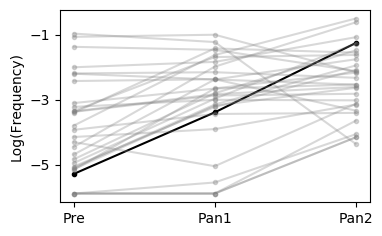

"RBD_FlagPanningAnalysis.csv"

In [10]:
#Calculating frequency over panning.
nam = "RBD_Flag"
to_plot = ["RBD-flag-P1","RBD-flag-P2"]
test_vec = ["Pre-TysonA.trimmed.fasta",
"Pre-TysonB.trimmed.fasta",
"RBD-flag-P1.trimmed.fasta",
"RBD-flag-P2.trimmed.fasta"];

#For regularization away from zero frequencies; derived from the total variants in the merged "pre" dataset.
total_pre_vars = length(read_fasta("Processed/Pre-TysonA.trimmed.fasta")) + length(read_fasta("Processed/Pre-TysonB.trimmed.fasta"))
nbseqs = []
nbnames = []
nb_pres = []
nb_p1s = []
nb_p2s = []
nb_delta = []
figure(figsize = (4,2.5))
for k in [1:length(qs);]
    queryseq = qs[k]
    queryname = qnames[k]
    hitnames,hitseqs = seq_neighbours(queryseq,"Processed/" .* test_vec, thresh = 0.03);
    cats = [split(i,"_")[1] for i in hitnames[2:end]];
    props = [parse(Float64,split(i,"_")[end]) for i in hitnames[2:end]];
    d = Dict()
    for c in union(cats)
        d[c] = sum(props[cats .== c])
    end
    pre = (get(d,"Pre-TysonA",0) + get(d,"Pre-TysonB",0))/2
    base = 1:length(to_plot)+1
    ys = [pre]
    for t in to_plot
        push!(ys,get(d,t,0))
    end
    col = "grey"
    al = 0.3
    if k == special
        col = "black"
        al = 1.0
    end
    #This is like a regularizer based on the fact that everything must have been there at least once
    log_ys = log10.(ys .+ 1/total_pre_vars)
    plot(base,log_ys,".",color = col,alpha = al)
    plot(base,log_ys,color = col,alpha = al)
    PyPlot.xticks([1,2,3],["Pre","Pan1","Pan2"]);
    yticks([-1,-3,-5])
    ylabel("Log(Frequency)")
    
    push!(nbseqs,queryseq)
    push!(nbnames,queryname)
    push!(nb_pres,log_ys[1])
    push!(nb_p1s,log_ys[2])
    push!(nb_p2s,log_ys[3])
    push!(nb_delta,log_ys[3] - log_ys[1])
end

savefig(nam*"_PanningFrequencies.pdf")

df = DataFrame()
df.names = nbnames
df.seqs = nbseqs
df.pre_freq = nb_pres
df.P1freq = nb_p1s
df.P2freq = nb_p2s
df.delta = nb_delta
CSV.write(nam*"PanningAnalysis.csv",df)